<font size="+3"><strong>6.5. Small Business Owners in the United States🇺🇸</strong></font>

### Welcome to the Clustering Credit-Challenged Households Using SCF 2019 Data Project!

This assignment is divided into two parts: Clustering small business owners by KMeans model, and Building an interactive Dash web.

**1. KMeans model:** In here you'll to focus on business owners in the United States. You'll start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. Then you'll select high-variance features, and create a clustering model to divide small business owners into subgroups. Finally, you'll create some visualizations to highlight the differences between these subgroups.

**2. Interactive Dash web:** You'll build a dash web by creating functions for each part of the model and use decorator to display it on your web.

Good luck! 🍀

#### 1. **KMeans model**

In [1]:
# Import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Prepare Data

## Import

#### Task 6.5.1 Read the contents of the file data/SCFP2019.csv.gz in a DataFrame df . 

In [2]:
df = pd.read_csv("data/SCFP2019.csv.gz")
print("df shape:", df.shape)
df.head()

df shape: (28885, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


## Explore

As mentioned at the start of this assignment, you're focusing on business owners. But what percentage of the respondents in `df` are business owners?

#### Task 6.5.2 Determine the proportion of respondents in df who are business owners by analyzing the "HBUS" column.

In [3]:
prop_biz_owners = df["HBUS"].value_counts(normalize=True).get(1)
print("proportion of business owners in df:", round(prop_biz_owners, 4))

proportion of business owners in df: 0.274


Is the distribution of income different for business owners and non-business owners?

#### Task 6.5.3
Create a DataFrame named df_inccat that shows the normalized frequency of income categories for both business owners and non-business owners using the "INCCAT" and "HBUS" columns. The data type in "INCCAT" column is categorical which represent income percentile groups, refer to the `Data dictionary`. Make sure to label the data type in this column appropiately as in the Data dictionary.

In [4]:
# Labels from the data dictionary
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100"
}

# Grouping biz_owners by method chaining
df_inccat = (
    df["INCCAT"].replace(inccat_dict)
    .groupby(df["HBUS"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


#### Task 6.5.4

Create a grouped bar chart that compares the income category distribution of business owners vs. non-business owners using the df_inccat DataFrame.

C:\Users\youke\AppData\Local\Temp\ipykernel_2856\3339838121.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


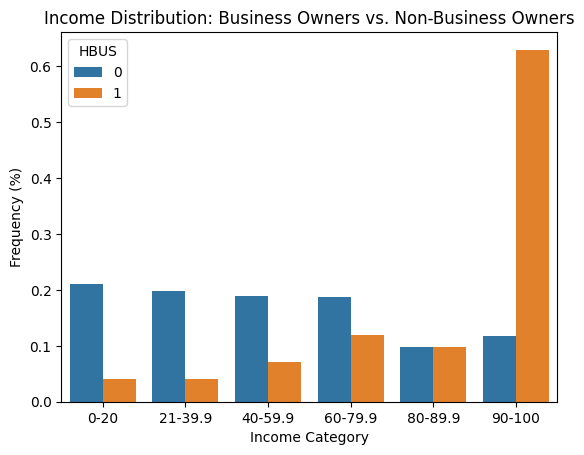

In [5]:
fig, ax = plt.subplots()

sns.barplot(
    data=df_inccat,
    x="INCCAT",
    y="frequency",
    hue="HBUS",
    order=inccat_dict.values()
)

ax.set_xlabel("Income Category")
ax.set_ylabel("Frequency (%)")
ax.set_title("Income Distribution: Business Owners vs. Non-Business Owners")
fig.show()

Are there notable differences between business owners and non-business owners?

#### Task 6.5.5
Create a scatter plot to examine the relationship between household debt and home value, distinguishing between business owners and non-business owners.

C:\Users\youke\AppData\Local\Temp\ipykernel_2856\2960112532.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


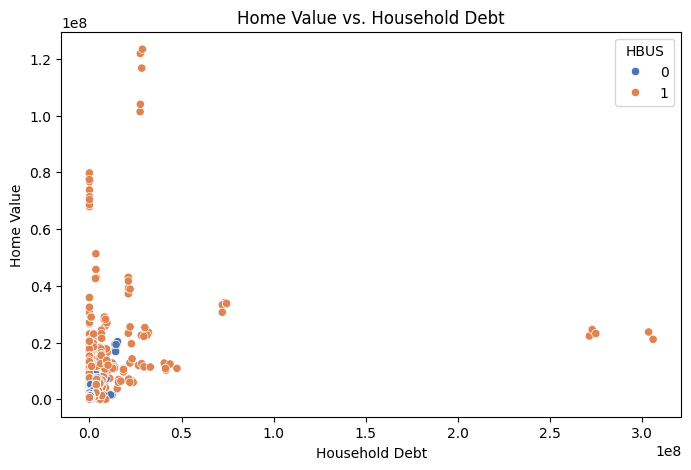

In [6]:
# Plot "HOUSES" vs "DEBT" with hue as business ownership
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(
    data=df,
    x="DEBT",
    y="HOUSES",
    hue="HBUS",
    palette="deep"
)
ax.set_xlabel("Household Debt")
ax.set_ylabel("Home Value")
ax.set_title("Home Value vs. Household Debt")

fig.show()

For the model building part of the assignment, you're going to focus on small business owners, defined as respondents who have a business and whose income does not exceed $500,000.

#### Task 6.5.6
Create a new DataFrame named df_small_biz that includes only respondents who are business owners (HBUS) and have household income less than $500,000. Use a boolean mask to apply both conditions and filter the df DataFrame accordingly.

In [7]:
mask = (df["HBUS"] == 1) & (df["INCOME"] < 5e5)
df_small_biz = df[mask] 
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4161, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


In the previous lecture, we saw that credit-fearful respondents were relatively young. Is the same true for small business owners?

#### Task 6.5.7
Create a histogram from the "AGE" column in df_small_biz with 10 bins.

C:\Users\youke\AppData\Local\Temp\ipykernel_2856\4055044124.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


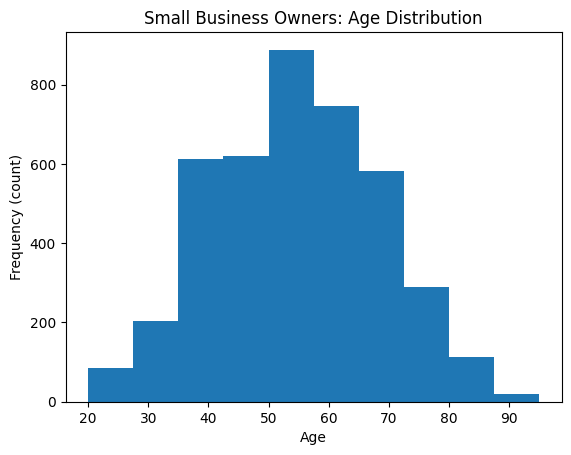

In [8]:
# Plot histogram of "AGE"
fig, ax = plt.subplots()
df_small_biz["AGE"].plot(kind="hist", bins=10)

ax.set_xlabel("Age")
ax.set_ylabel("Frequency (count)")
ax.set_title("Small Business Owners: Age Distribution")

fig.show()

Let's take a look at the variance in the dataset.

#### Task 6.5.8
Calculate the variance for all the features in df_small_biz, and create a Series top_ten_var with the 10 features with the largest variance.

In [9]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.336901e+13
FIN         2.629518e+13
KGBUS       6.053296e+13
ACTBUS      6.432674e+13
BUS         6.670909e+13
KGTOTAL     7.454386e+13
NFIN        1.149004e+14
NHNFIN      1.196403e+14
NETWORTH    1.796109e+14
ASSET       1.928282e+14
dtype: float64

#### Task 6.5.9
The normal variance might be influenced by extreme outliers. Calculate the trimmed variance for the features in df_small_biz. Your calculations should not include the top and bottom 10% of observations. Then create a Series top_ten_trim_var with the 10 features with the largest variance.

In [10]:
# Calculate trimmed variance
top_ten_trim_var = (
    df_small_biz.apply(trimmed_var).sort_values().tail(10)
)

top_ten_trim_var

EQUITY      1.143799e+11
KGBUS       1.906260e+11
FIN         3.649923e+11
KGTOTAL     5.790939e+11
ACTBUS      6.173616e+11
BUS         7.274641e+11
NHNFIN      1.696410e+12
NFIN        2.074082e+12
NETWORTH    4.124869e+12
ASSET       4.453857e+12
dtype: float64

#### Task 6.5.10
Create a horizontal bar chart showing the top 10 features with the highest trimmed variance among small business owners. Label your axes appropiately and add title.

In [11]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(x=top_ten_trim_var,
            y=top_ten_trim_var.index,
            title="Small Business Owners: High Variance Features")

fig.update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")

fig.show()

#### Task 6.5.11
Using top_ten_trim_var generate a list called high_var_cols with the column names of the five features with the highest trimmed variance.

In [12]:
high_var_cols = top_ten_trim_var[5:].index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

## Split

Let's turn that list into a feature matrix.

#### Task 6.5.12
Define a feature matrix X from df_small_biz. It should contain the five columns in high_var_cols.

In [13]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4161, 5)


,BUS,NHNFIN,NFIN,NETWORTH,ASSET
80,0.0,301001.55074,839264.63576,275427.17881,939651.81457
81,0.0,299657.79382,838105.43046,274267.97351,938492.60927
82,0.0,301001.55074,839264.63576,275427.17881,939651.81457
83,0.0,298314.03689,836946.22517,271949.56291,937333.40397
84,0.0,299657.79382,838105.43046,275427.17881,938492.60927


# Build Model

## Iterate

#### Task 6.5.13
Before building the actual KMeans model, you'll need to tune your hyperparamters for your model by iterating different values of n_clusters, ranging from 2 to 12.

Then for each cluster, build model and fit a pipeline with StandardScaler and KMeans and add a random_state. Append model's inertia to empty inertia_errors list and silhouette score to empty silhouette_scores list throughout the iteration.

In [14]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = make_pipeline(
        StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5419.0220308856005, 2902.1600402045915, 2082.5056428560547, 1550.8719011833057, 1436.0526578602821, 1114.3403633878006, 825.1316466474685, 710.312403324444, 630.8391328158656, 542.8434708617599, 490.04945404714505]

Silhouette Scores: [np.float64(0.962230513495831), np.float64(0.852409870333528), np.float64(0.756703930205641)]


Next, try to figure out how many clusters you'll need with a line plot based on Inertia and Silhouette Scores.

#### Task 6.5.14
Use plotly express to create a line plot that shows the values of inertia_errors as a function of n_clusters. 

In [15]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors,
    title="K-Means Model: Inertia vs Number of Clusters"
)

fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

#### Task 6.5.15
Use plotly.express.line() to create a line plot that shows the values of silhouette_scores as a function of n_clusters.

In [16]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)

fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")
fig.show()

How many clusters should you use? When you've made a decision about that, it's time to build the final model.

#### Task 6.5.16
Build and train a new k-means model named final_model. Using Standard Scaler and Kmeans clustering. For reproducibility, set the random state for your model to 42. 

In [17]:
final_model = make_pipeline(
    StandardScaler(), KMeans(n_clusters=4, random_state=42))

final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

# Communicate

Now it's the time share your work! 

#### Task 6.5.17
Access the cluster labels from your trained final_model pipeline. Then group the standardized feature set X by these labels and compute the mean of each feature for every cluster. Store the result in a DataFrame named xgb.

In [18]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,4.497673e+05,7.647058e+05,1.117192e+06,1.572432e+06,1.785395e+06
1,7.903614e+07,1.107909e+08,1.086599e+08,1.364957e+08,1.409950e+08
2,5.899181e+06,9.129588e+06,9.828339e+06,1.199142e+07,1.266813e+07
3,2.659238e+07,3.384027e+07,3.196646e+07,4.376968e+07,4.515401e+07


As usual, make a visualization with the DataFrame.

#### Task 6.5.18
Use plotly.express to create a side-by-side grouped bar chart that visualizes the values in the DataFrame xgb. Label your axes appropiately and add title.

In [19]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    data_frame=xgb,
    barmode="group",
    title="Small Business Owner Finances by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

Remember what we did with higher-dimension data last time? Apply the same thing here.

#### Task 6.5.19
Create a PCA transformer to reduce the dimensionality of the dataset X to 2 components. Apply this transformer to X and store the resulting transformed data in a DataFrame named X_pca. Name the columns of X_pca as "PC1" and "PC2".

In [20]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4161, 2)


,PC1,PC2
0,-6.686449e+06,486521.529763
1,-6.688719e+06,486559.551389
2,-6.686449e+06,486521.529763
3,-6.691592e+06,487132.682567
4,-6.688117e+06,486024.441835


#### Task 6.5.20
Use plotly.express to create a scatter plot that visualizes the PCA-transformed data in X_pca. Color the points with labels from the model.

In [21]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca, x="PC1", y="PC2", 
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)

fig.update_layout(xaxis_title="PC1", yaxis_title="PC2", legend_title_text="Clusters")

fig.show()

You've built your KMeans model, it's time to show and display it on an interactive Dash web. Now proceed to the next part of this project.